# Edinburgh Airbnb Data Preparation

This notebook handles the loading, exploration, cleaning, and preparation of the Airbnb Listing Data.
## 1. Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
from geo_northarrow import add_north_arrow
from matplotlib_scalebar.scalebar import ScaleBar

# Load Cambria font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf"  # Adjust path if needed
cambria_prop = fm.FontProperties(fname=cambria_path)

## 2. Load Airbnb Data

In [2]:
# Read in csv file
edinburgh_airbnb = pd.read_csv('../../data/edinburgh/edinburgh_listings.csv')

# Read in glx town boundaries for Edinburgh
edinburgh_glx = gpd.read_file('../../data/edinburgh/edinburgh_seamless.gpkg')

In [3]:
# Print the column names of the Edinburgh Airbnb data
edinburgh_airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
# Keep only relevant columns
edinburgh_airbnb = edinburgh_airbnb[["id", "listing_url", "name", "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "accommodates", "availability_eoy", "estimated_occupancy_l365d", "price", "estimated_revenue_l365d", "longitude", "latitude"]]

In [5]:
# Convert to GeoDataFrame
edinburgh_airbnb = gpd.GeoDataFrame(
    edinburgh_airbnb,
    geometry = gpd.points_from_xy(edinburgh_airbnb['longitude'], edinburgh_airbnb['latitude']),
    crs = 'EPSG:4326'
)

## 3. Exploration and Cleaning

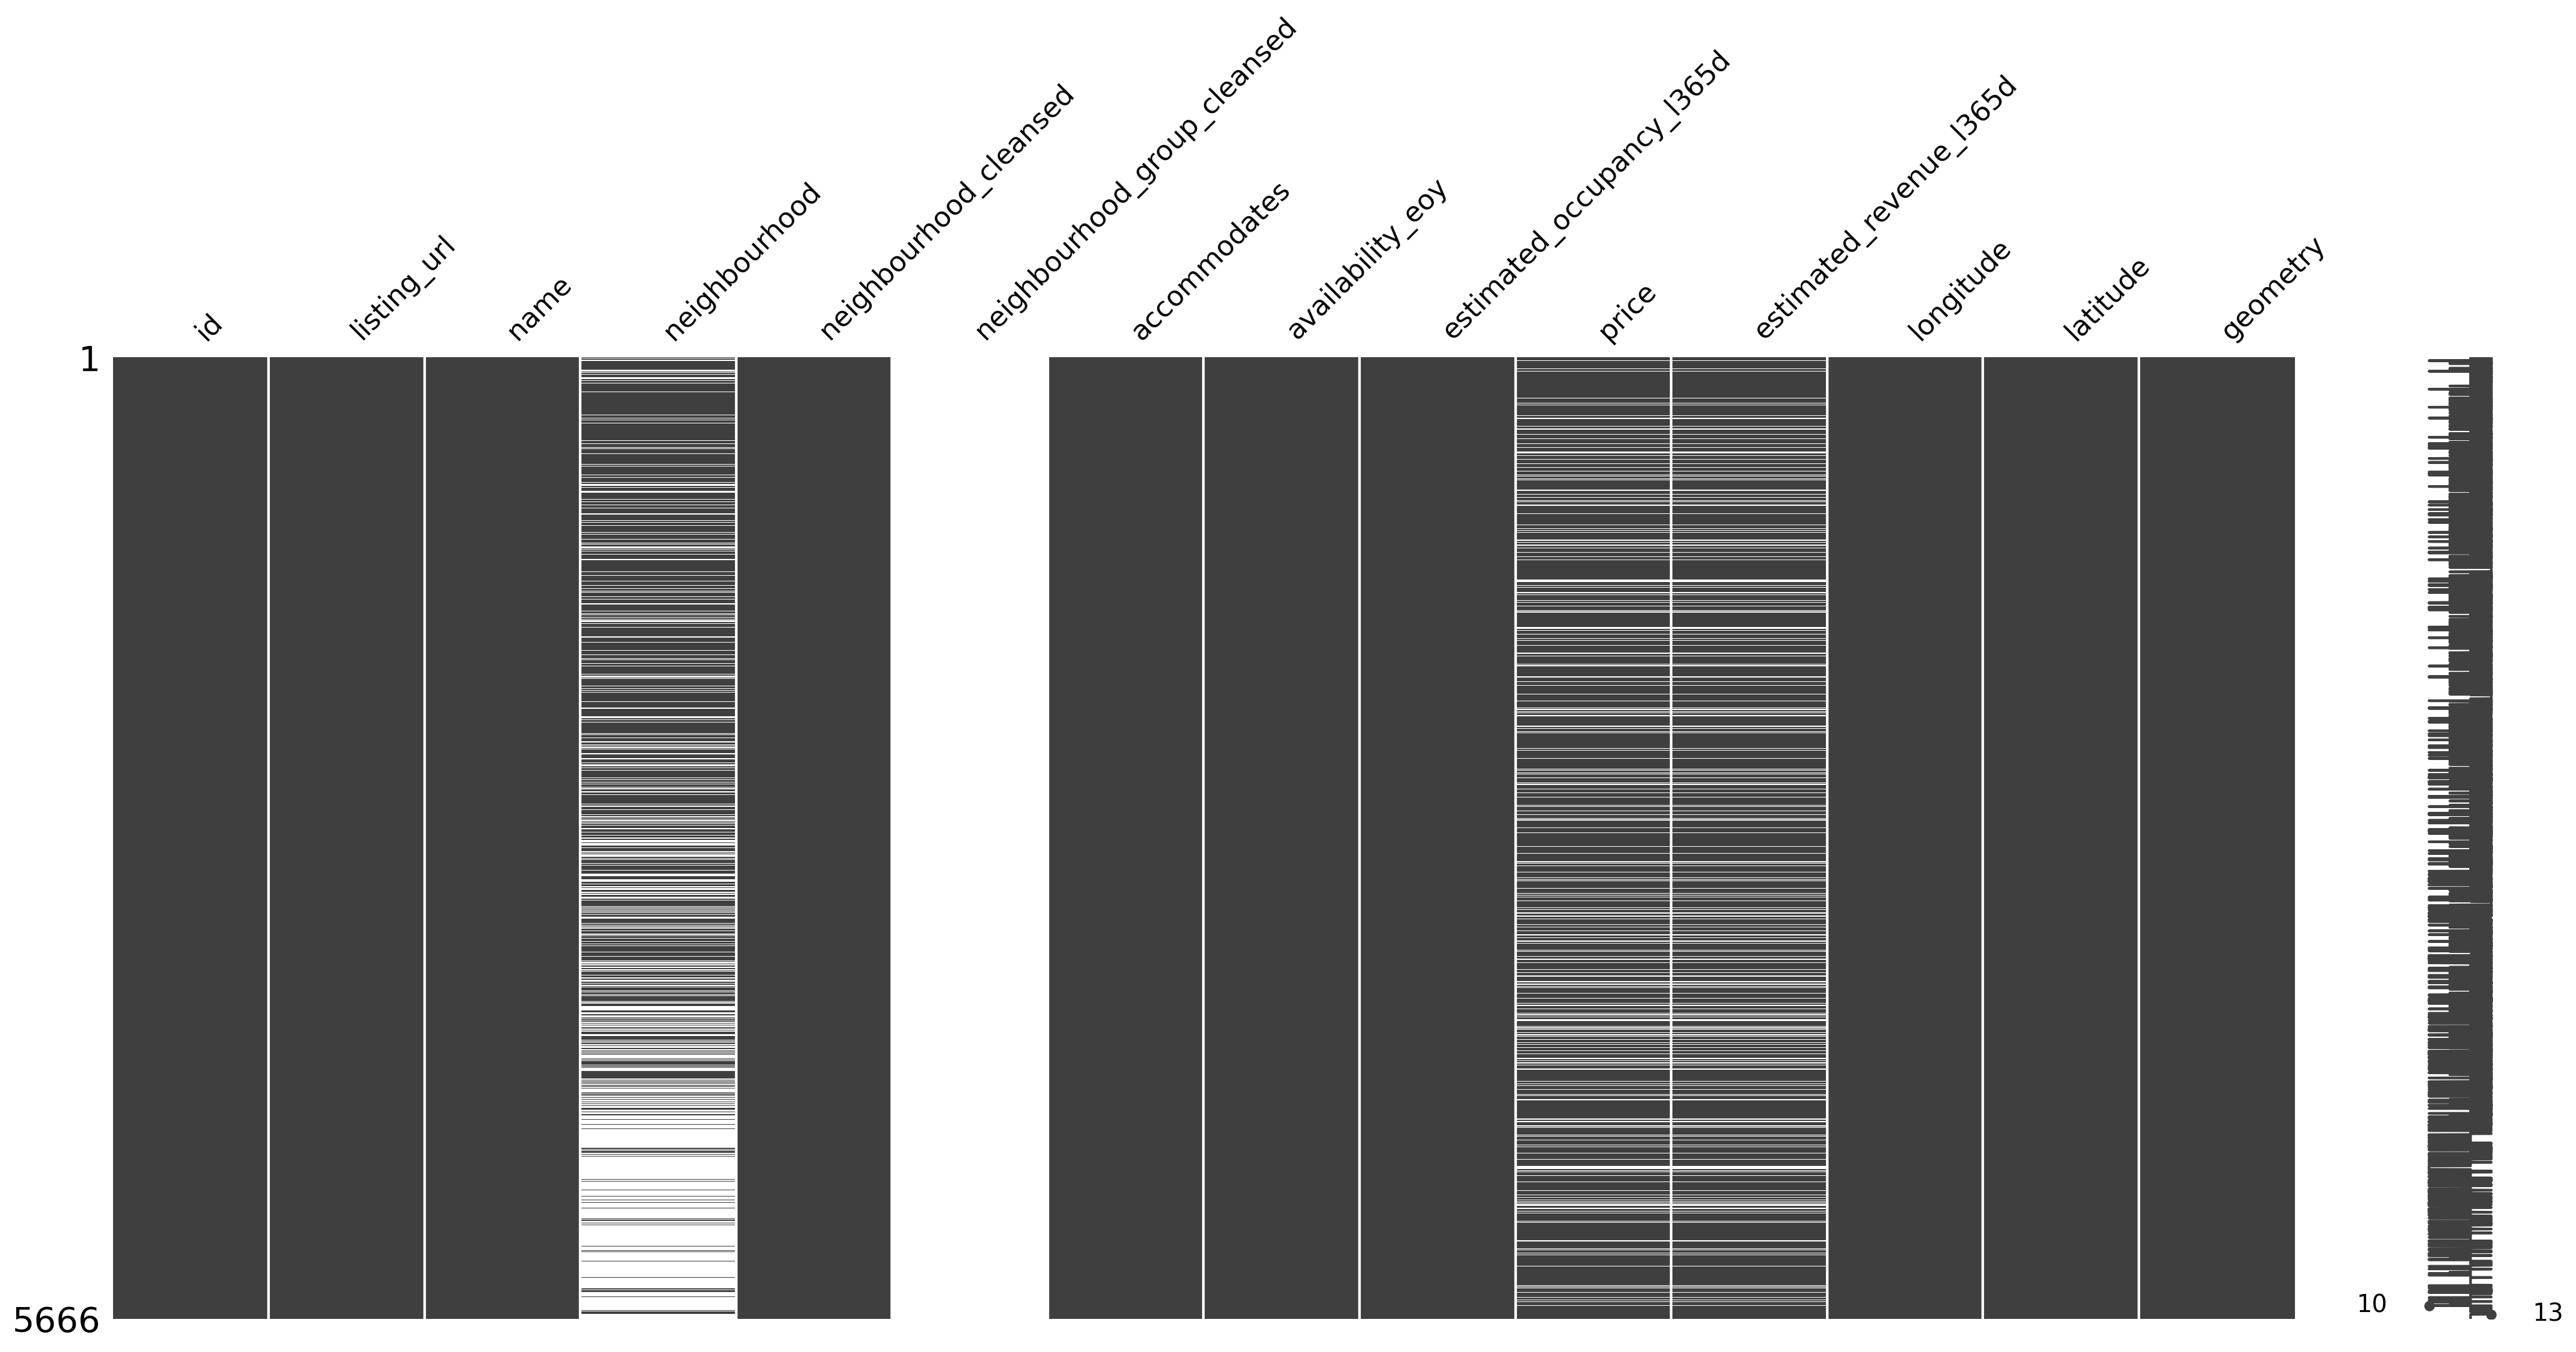

In [6]:
# Check for missing values
msno.matrix(edinburgh_airbnb);

In [7]:
# Remove properties where 'price' is NA
edinburgh_airbnb = edinburgh_airbnb.dropna(subset=['price'])

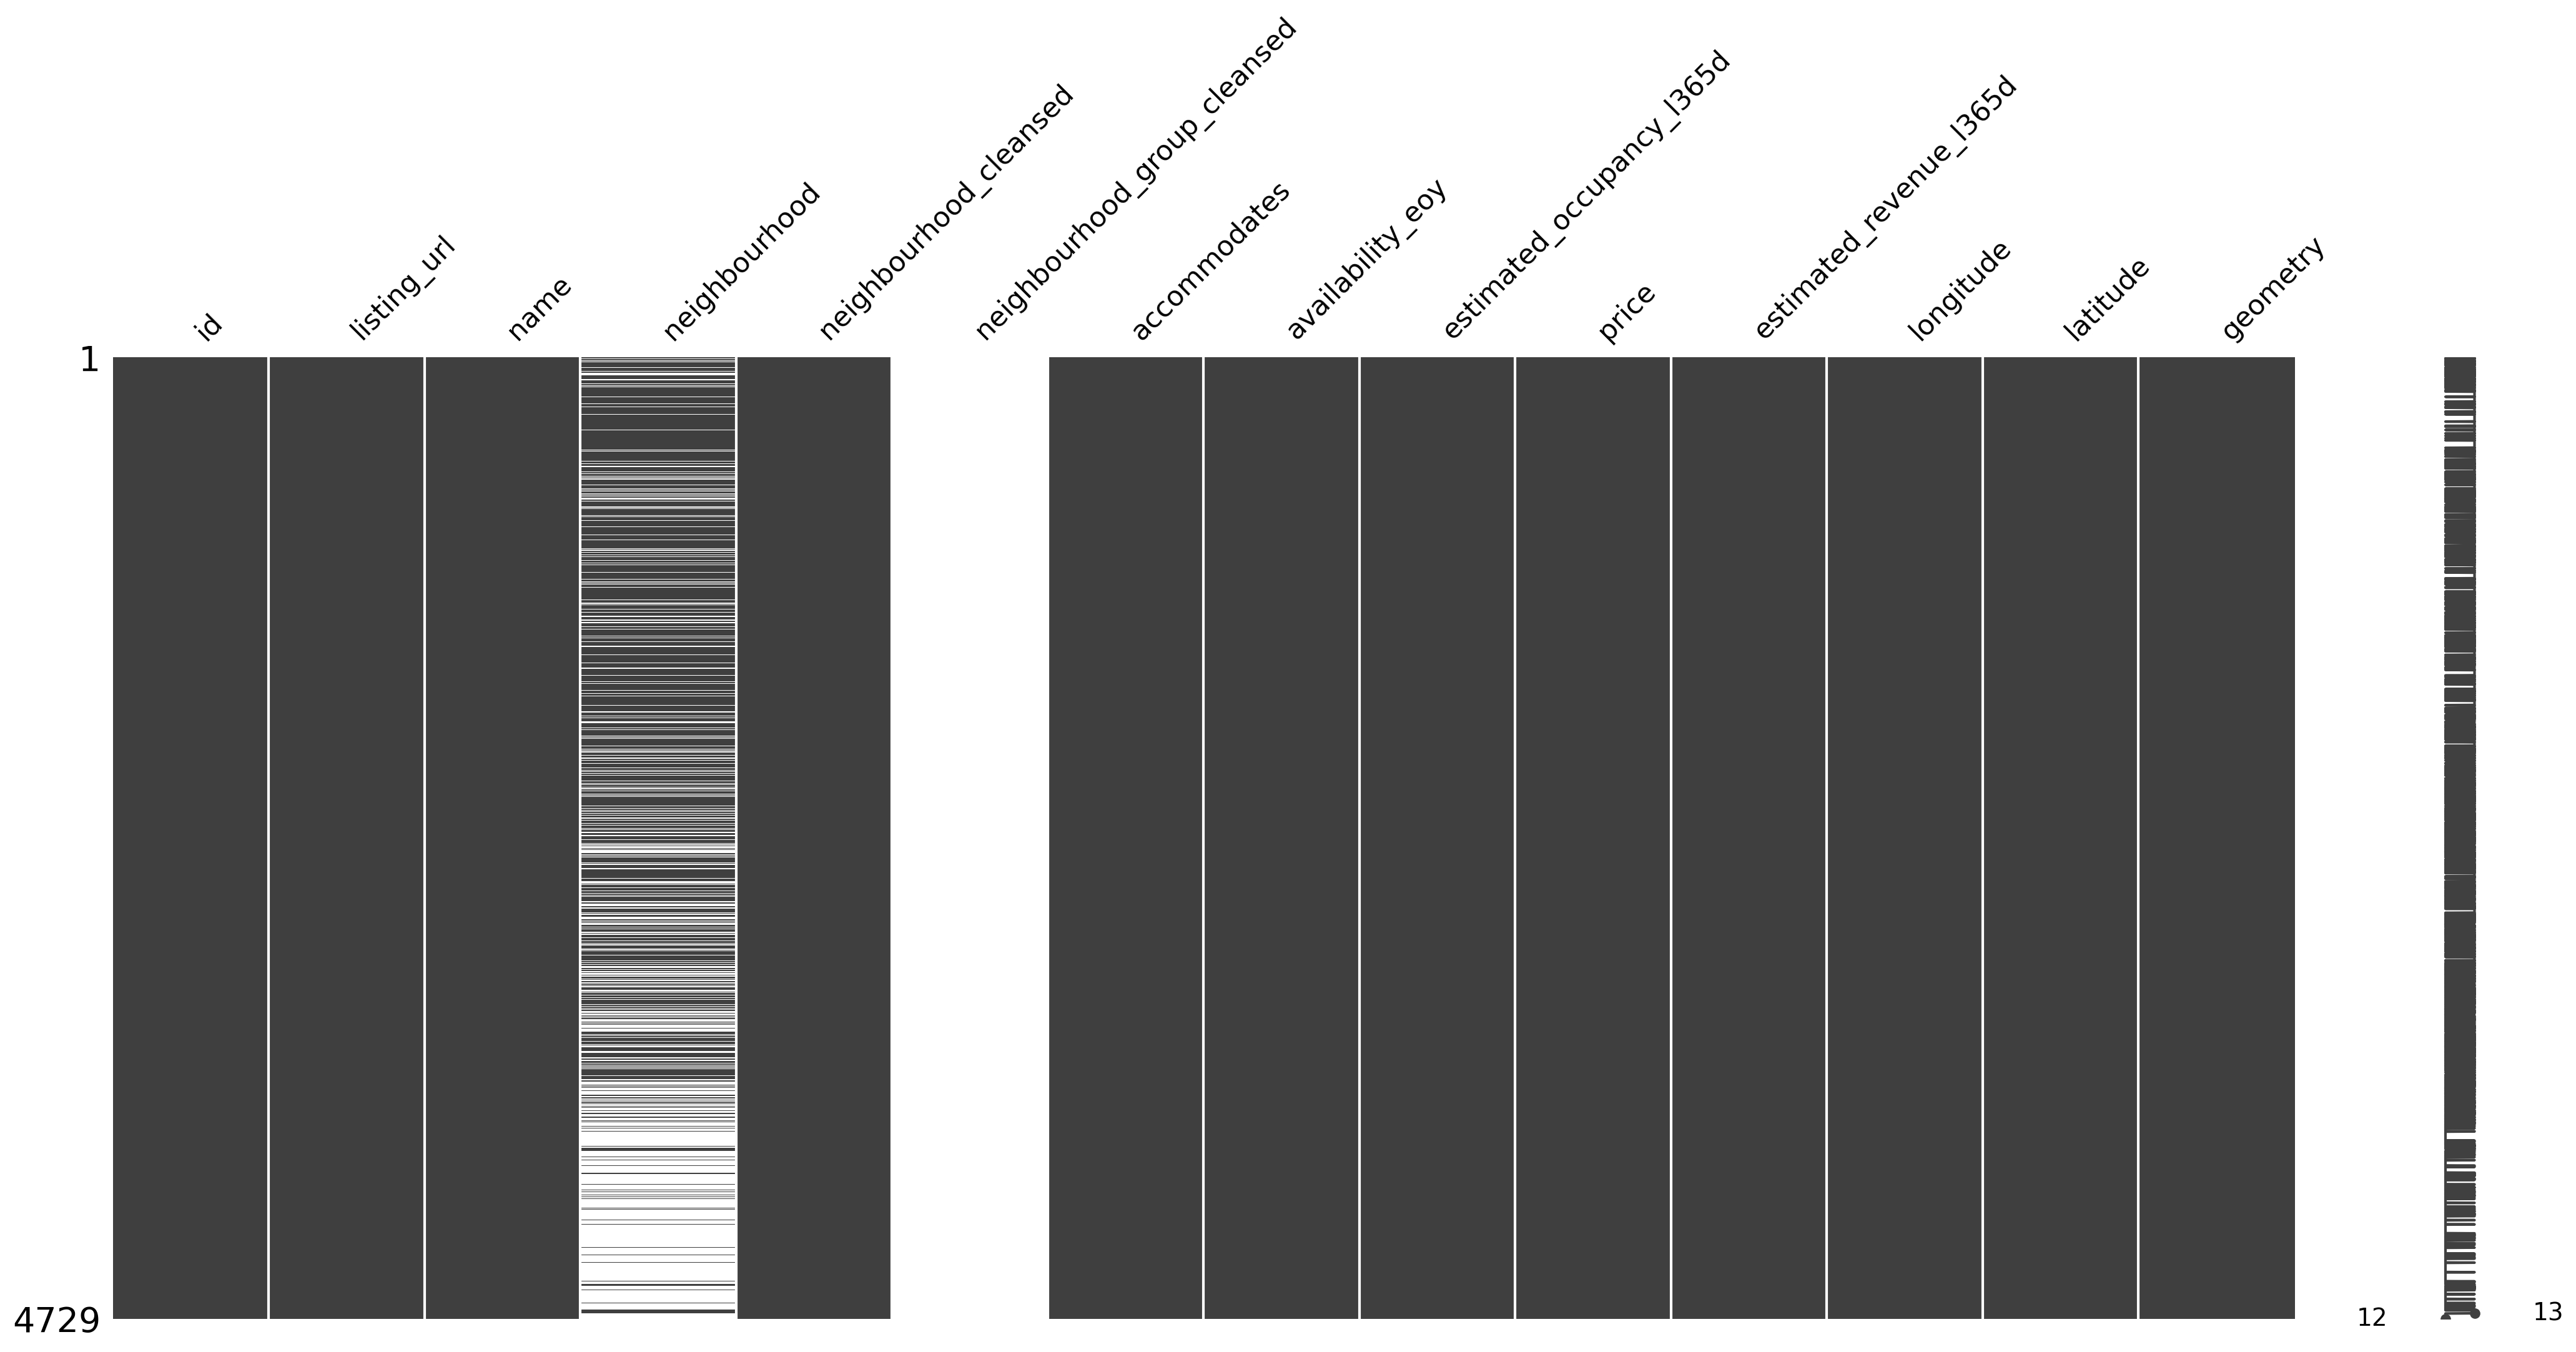

In [8]:
msno.matrix(edinburgh_airbnb);

A total of 937 (16%) have been dropped.

In [9]:
# Remove currency symbols and commas, then convert to float
edinburgh_airbnb['price'] = (
    edinburgh_airbnb['price']
    .replace('[\\$,]', '', regex=True)  # Remove $ and , characters
    .astype(float)
)

In [10]:
# Drop listings with zero price
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['price'] > 0]
# Drop listings with zero estimated_occupancy
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['estimated_occupancy_l365d'] > 0]
# Drop listings with zero accommodates
edinburgh_airbnb = edinburgh_airbnb[edinburgh_airbnb['accommodates'] > 0]

In [11]:
# Find total number of properties in the dataset
total_properties = len(edinburgh_airbnb)
print(f'Total number of properties: {total_properties}')

Total number of properties: 4123


After cleaning, a total of 1,543 (27%) listings have been dropped.

In [12]:
# Rename the id column in edinburgh_glx to glx_id
edinburgh_glx = edinburgh_glx.rename(columns={'id': 'glx_id'})

# Spatial join to attach glx_id to each Airbnb within the boundaries
edinburgh_airbnb_clipped = gpd.sjoin(
    edinburgh_airbnb, edinburgh_glx[['glx_id', 'geometry']],
    how = 'inner', predicate = 'within'
).copy()

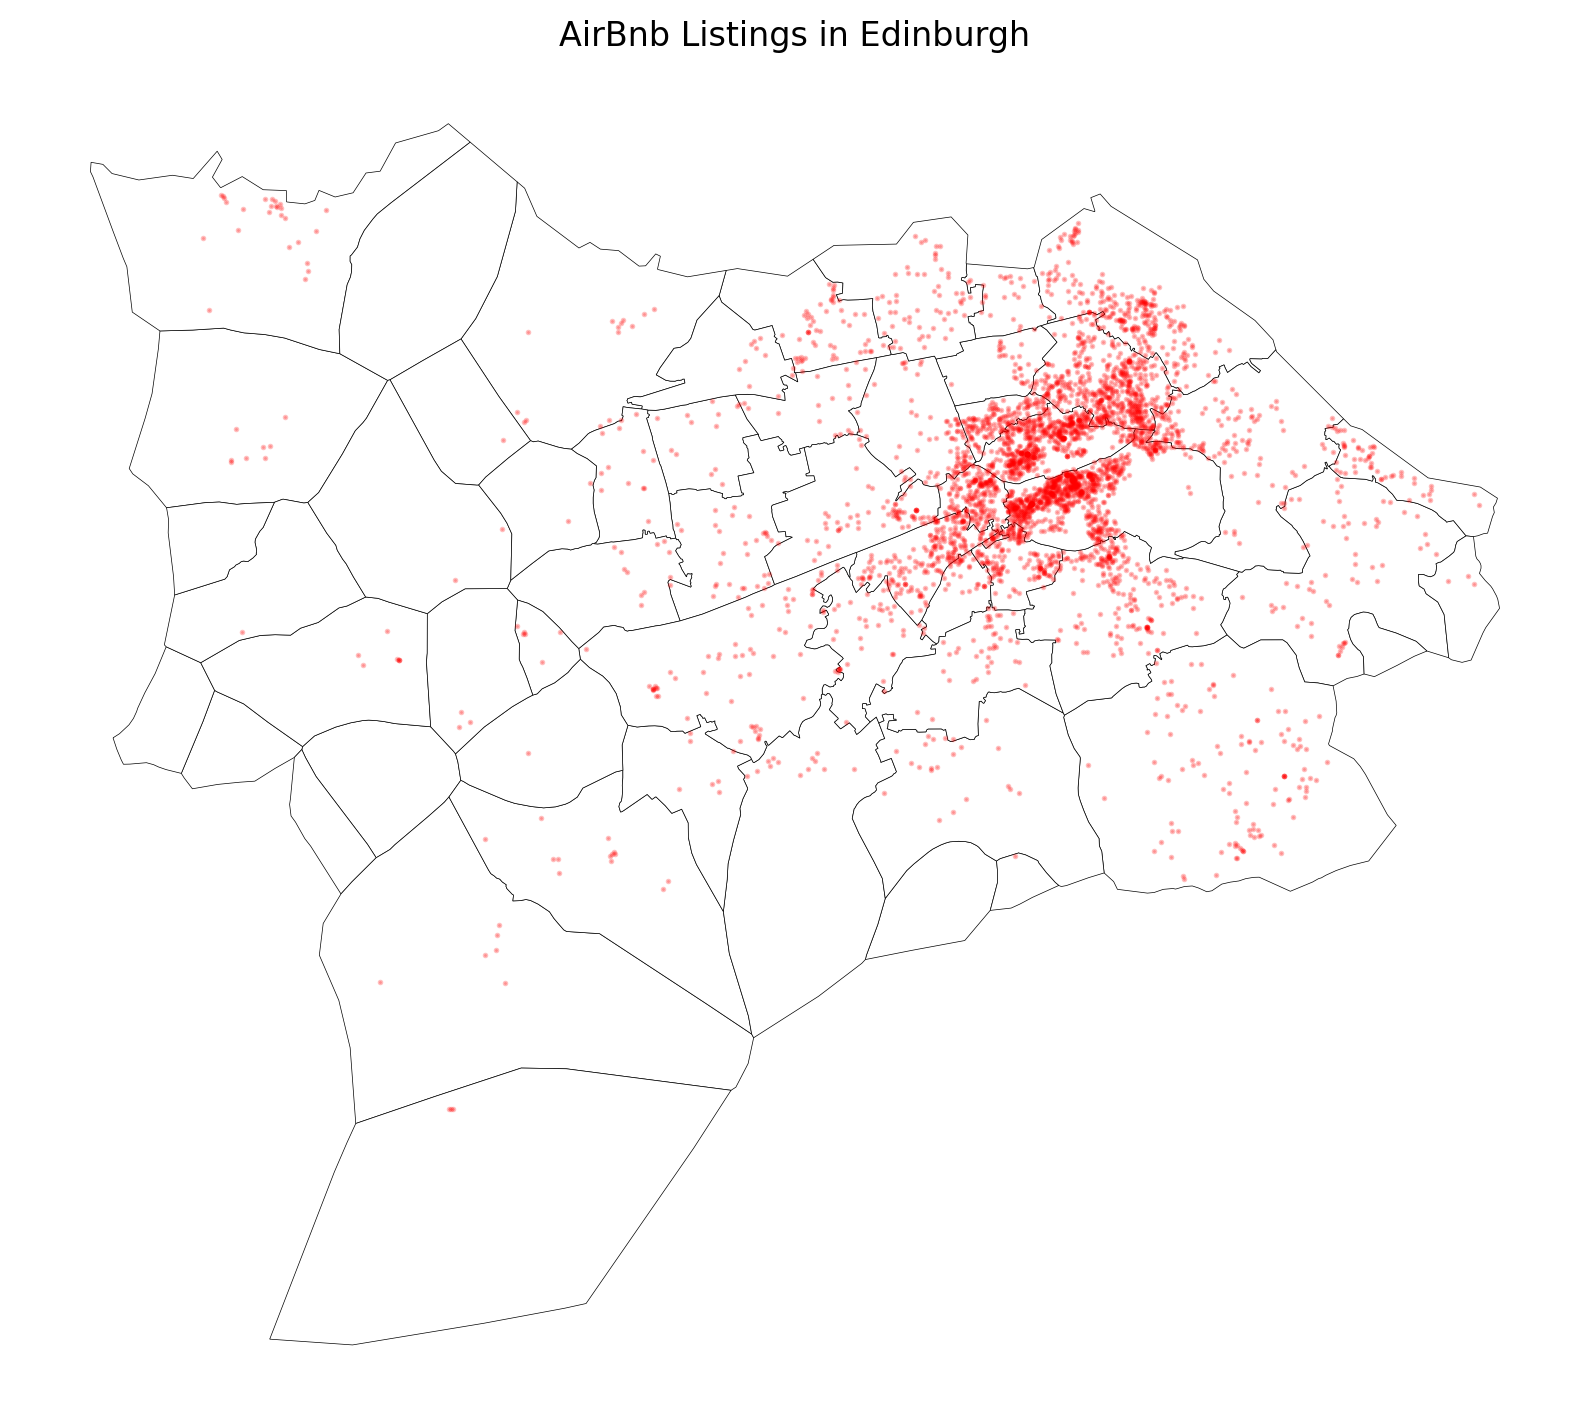

In [13]:
# Plot airbnbs
ax = edinburgh_glx.plot(figsize=(10, 10), color='white', edgecolor='black', linewidth=0.25)
# Plot the points
edinburgh_airbnb_clipped.plot(ax=ax, color = 'red', markersize=1, alpha=0.25)

ax.set_title("AirBnb Listings in Edinburgh")
ax.set_axis_off()

## 4. Feature Engineering
### Guest Volume

In [14]:
# Calculate the actual guest volume - i.e. an estimate of how many people actually stayed there in the past year
edinburgh_airbnb_clipped['estimated_guest_volume'] = (
    edinburgh_airbnb_clipped['accommodates'] *
    edinburgh_airbnb_clipped['estimated_occupancy_l365d']
)

### Variables by Town

In [15]:
# Get the number of properties in each town
edinburgh_airbnb_counts = (
    edinburgh_airbnb_clipped
    .groupby(['glx_id'])
    .size()
    .reset_index(name='property_count')
)

# Rename id column in edinburgh_glx to glx_id
edinburgh_glx = edinburgh_glx.rename(columns = {'id': 'glx_id'})

# Merge with geoms
edinburgh_glx_with_counts = edinburgh_glx.merge(
    edinburgh_airbnb_counts,
    on = "glx_id",
    how = "left"
)

# Fill NaN property counts with 0 (for LSOAs that had no listings)
edinburgh_glx_with_counts['property_count'] = edinburgh_glx_with_counts['property_count'].fillna(0).astype(int)

### Total count of listings

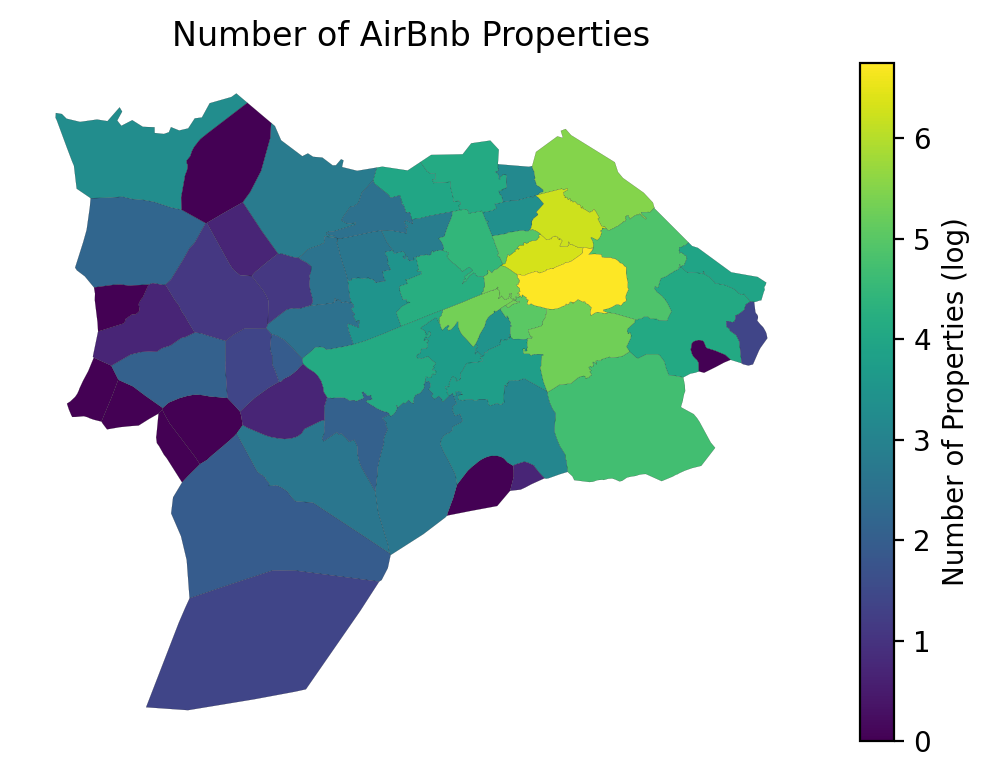

In [16]:
# Create log column
edinburgh_glx_with_counts['property_count_log'] = np.log1p(edinburgh_glx_with_counts['property_count'])

# Plot the counts
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

edinburgh_glx_with_counts.plot(
    column = 'property_count_log',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties (log)", 'orientation': "vertical"}
)
ax.set_title("Number of AirBnb Properties", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Density of Listings

In [17]:
# Reproject to a projected CRS
edinburgh_glx_with_density = edinburgh_glx_with_counts.to_crs(epsg=27700)

# Now calculate density correctly (properties per square meter)
edinburgh_glx_with_density['density_m2'] = edinburgh_glx_with_density['property_count'] / edinburgh_glx_with_density.geometry.area

# Per square kilometer
edinburgh_glx_with_density['density_km2'] = edinburgh_glx_with_density['density_m2'] / 1e6

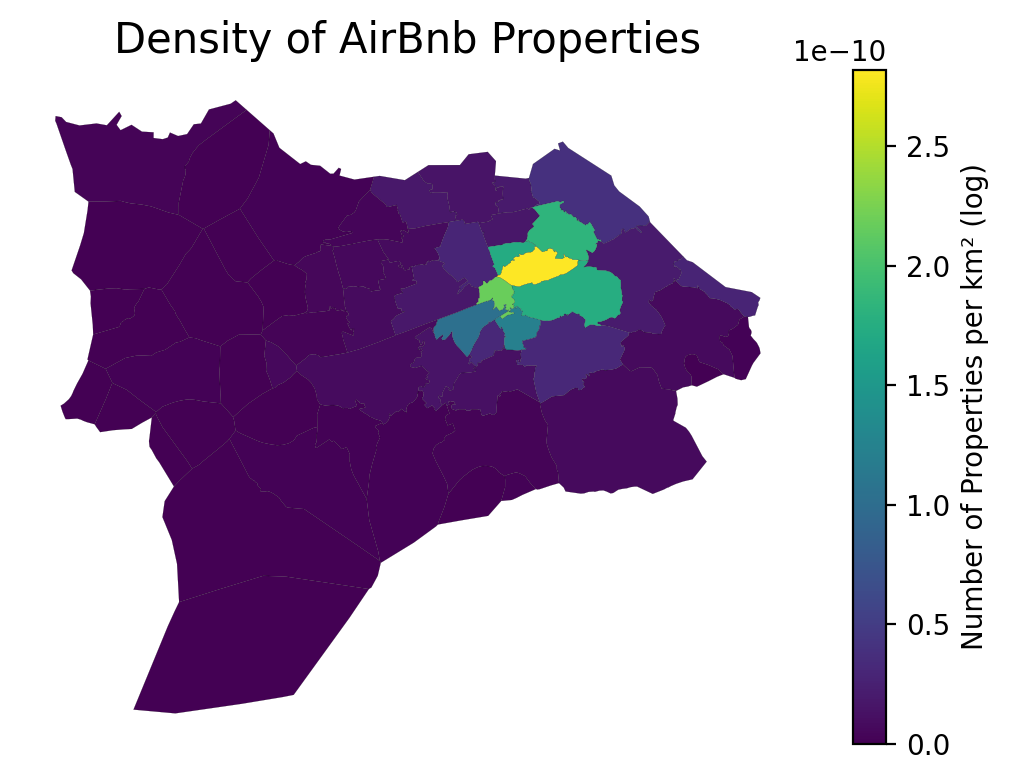

In [18]:
# Log the density
edinburgh_glx_with_density['log_density_km2'] = np.log1p(edinburgh_glx_with_density['density_km2'])

edinburgh_glx_with_density['log_density_m2'] = np.log1p(edinburgh_glx_with_density['density_m2'])

# Plot the density
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

edinburgh_glx_with_density.plot(
    column = 'density_km2',
    cmap = 'viridis',
    legend = True,
    ax = ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of Properties per km² (log)", 'orientation': "vertical"}
)
ax.set_title("Density of AirBnb Properties", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [23]:
edinburgh_glx_with_density.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### Model Target Variables

In [19]:
edinburgh_airbnb_clipped = edinburgh_airbnb_clipped.to_crs(epsg='4326')

In [20]:
airbnb_per_edinburgh_glx = edinburgh_airbnb_clipped.groupby(['glx_id']).agg(
    num_properties = ('id', 'count'),
    total_revenue = ('estimated_revenue_l365d', 'sum'),
    total_volume = ('estimated_guest_volume', 'sum')
).reset_index()

# Round all columns to 2 decimal places
for col in airbnb_per_edinburgh_glx.columns:
    if col not in ['glx_id']:
        airbnb_per_edinburgh_glx[col] = airbnb_per_edinburgh_glx[col].round(2)

airbnb_per_edinburgh_glx = edinburgh_glx_with_counts[['glx_id', 'geometry']].merge(
    airbnb_per_edinburgh_glx,
    on = ['glx_id'],
    how = 'left'
)

# Convert to geoDataFrame
airbnb_per_edinburgh_glx = gpd.GeoDataFrame(
    airbnb_per_edinburgh_glx,
    geometry=airbnb_per_edinburgh_glx['geometry'],
    crs = "EPSG:4326"
)

# Join the density data
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.merge(
    edinburgh_glx_with_density[["glx_id", "density_m2", "density_km2"]],
    on = "glx_id",
    how = 'left'
)

# Create logged versions of each of the columns
airbnb_per_edinburgh_glx['num_properties_log'] = np.log1p(airbnb_per_edinburgh_glx['num_properties'])
airbnb_per_edinburgh_glx['density_m2_log'] = np.log1p(airbnb_per_edinburgh_glx['density_m2'])
airbnb_per_edinburgh_glx['density_km2_log'] = np.log1p(airbnb_per_edinburgh_glx['density_km2'])
airbnb_per_edinburgh_glx['total_revenue_log'] = np.log1p(airbnb_per_edinburgh_glx['total_revenue'])
airbnb_per_edinburgh_glx['total_volume_log'] = np.log1p(airbnb_per_edinburgh_glx['total_volume'])

In [21]:
# Set EPSG:4326 as the CRS for the GeoDataFrame
airbnb_per_edinburgh_glx.crs = "EPSG:27700"

# Calculate the tourism intensity volume / area of the town
airbnb_per_edinburgh_glx['total_tourism_intensity'] = (
    airbnb_per_edinburgh_glx['total_volume'] /
    airbnb_per_edinburgh_glx.geometry.area
)

# Per square kilometer
airbnb_per_edinburgh_glx['total_tourism_intensity_km2'] = airbnb_per_edinburgh_glx['total_tourism_intensity'] / 1e6

# Log them
airbnb_per_edinburgh_glx['total_tourism_intensity_km2_log'] = np.log1p(airbnb_per_edinburgh_glx['total_tourism_intensity_km2'])

# Remove the intensity columns that are not per km2
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.drop(columns=['total_tourism_intensity'])

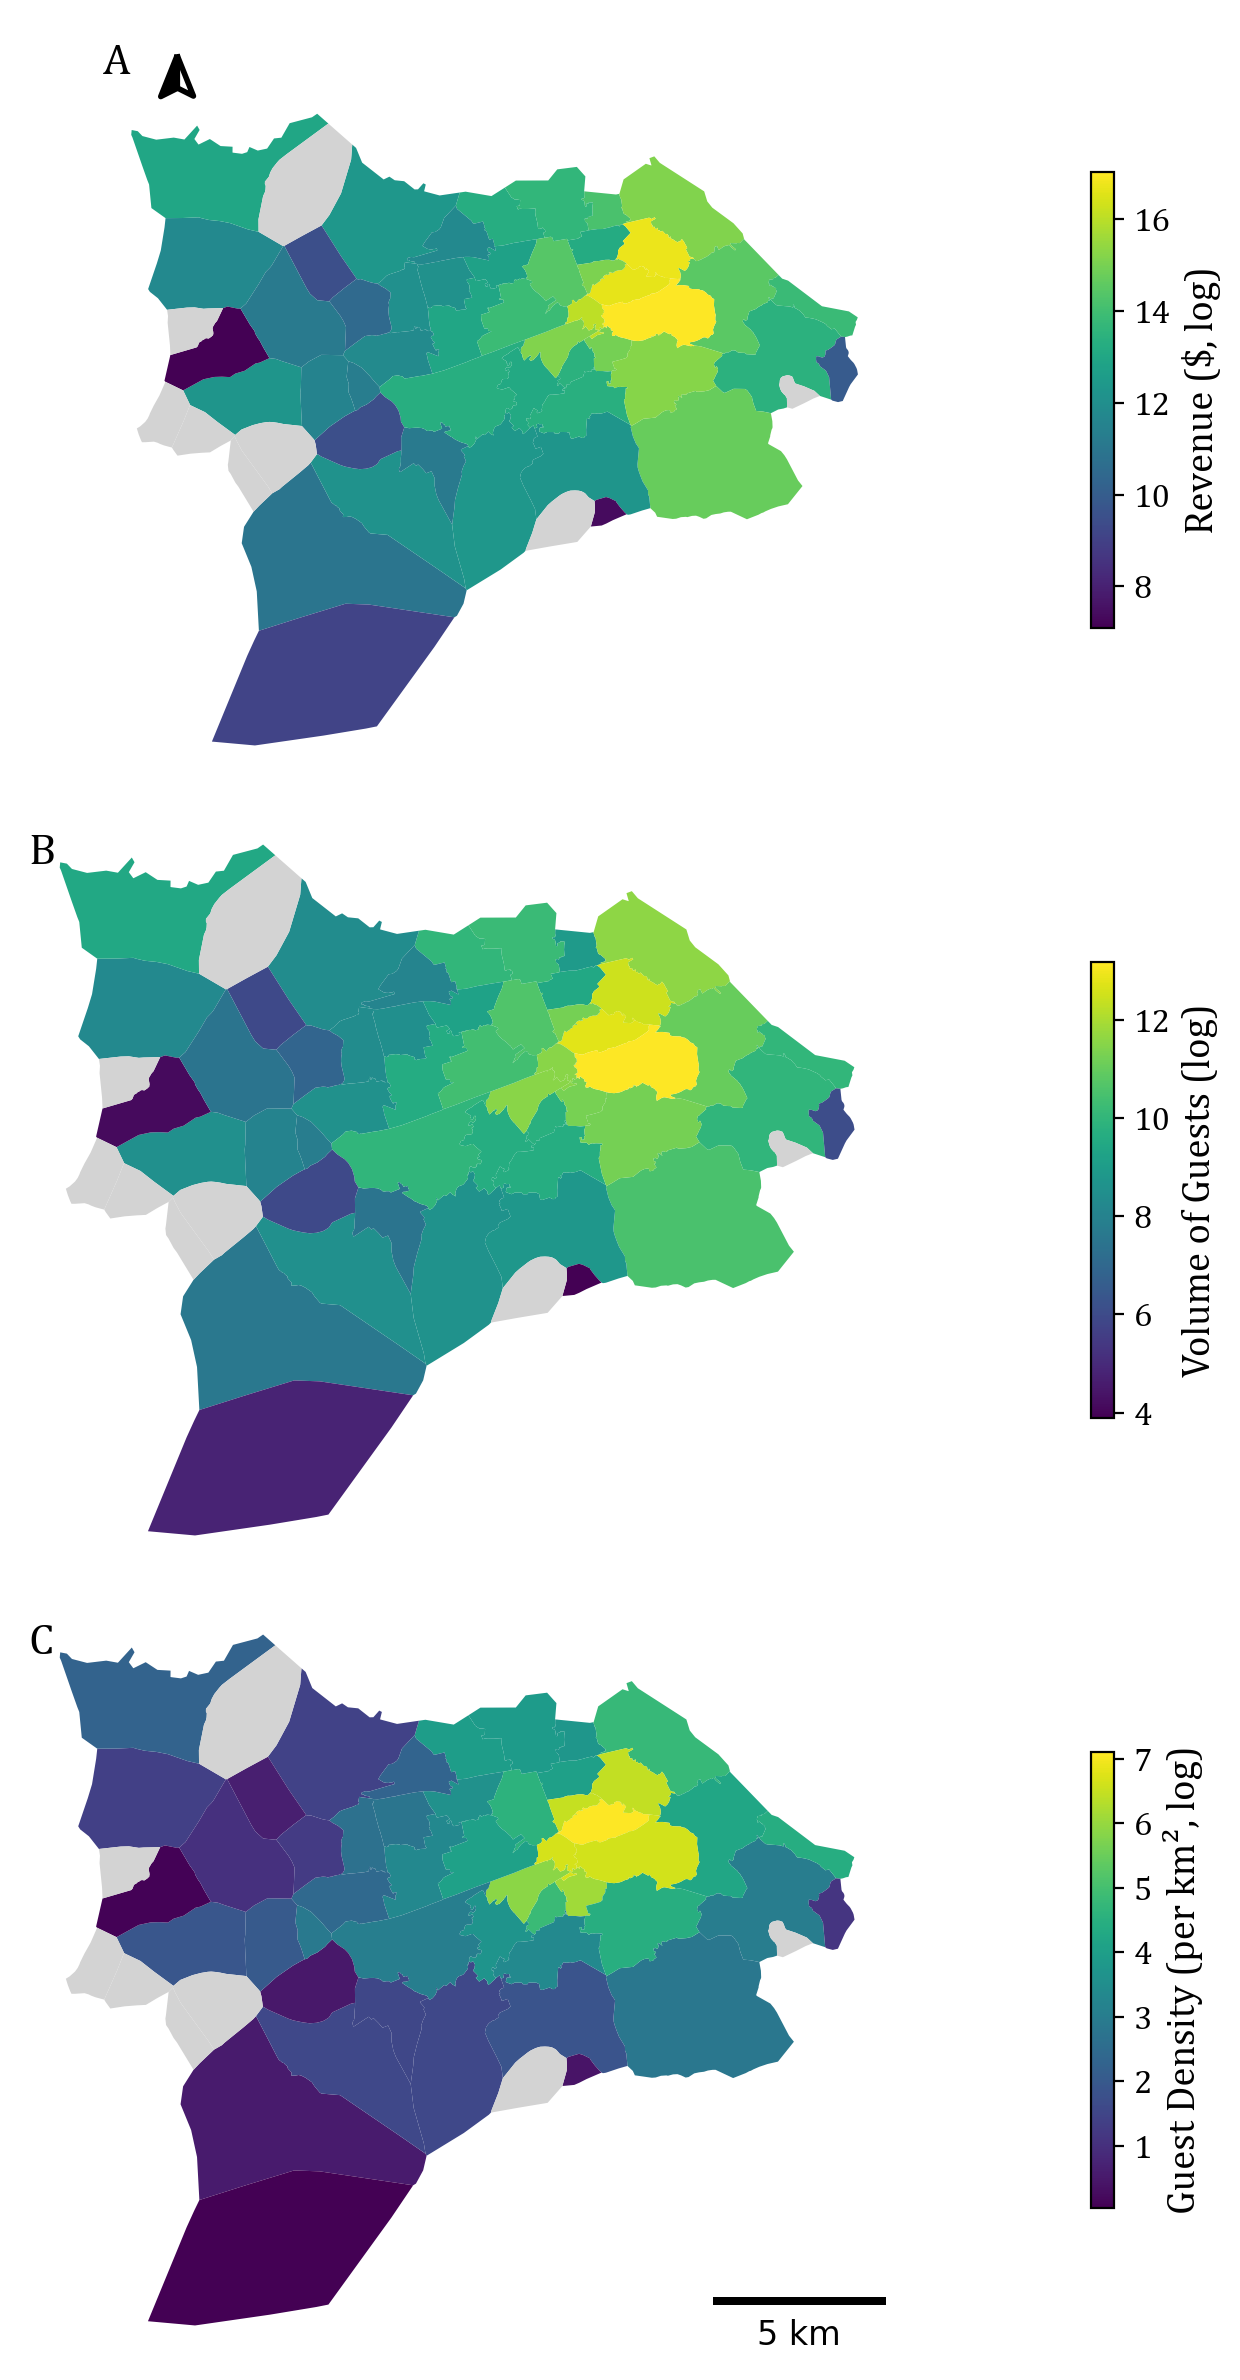

In [26]:
## Fix geometry
# Ensure both have glx_id as str or int consistently
edinburgh_geom = edinburgh_glx[['glx_id', 'geometry']]
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.drop(columns='geometry', errors='ignore')  # remove old if exists

# Merge on glx_id to get geometry in correct order
airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.merge(
    edinburgh_geom, on='glx_id', how='left'
)

# Convert to GeoDataFrame
airbnb_per_edinburgh_glx = gpd.GeoDataFrame(airbnb_per_edinburgh_glx, geometry='geometry', crs=edinburgh_glx.crs)

airbnb_plot_cols_log = [
    'total_revenue_log',
    'total_volume_log',
    'total_tourism_intensity_km2_log'
]

legend_titles_log = {
    'total_revenue_log': 'Revenue ($, log)',
    'total_volume_log' : 'Volume of Guests (log)',
    'total_tourism_intensity_km2_log': 'Guest Density (per km², log)',
}

airbnb_per_edinburgh_glx = airbnb_per_edinburgh_glx.to_crs(epsg=27700)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))
axes = axes.flatten()

for i, column in enumerate(airbnb_plot_cols_log):
    ax = axes[i]

    plot_obj = airbnb_per_edinburgh_glx.plot(
    column=column,
    ax=ax,
    cmap='viridis',
    legend=True,
    legend_kwds={'label': legend_titles_log.get(column, column), 'shrink': 0.6},
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

    # Access colorbar from the figure
    fig = plot_obj.get_figure()
    cbar_ax = fig.axes[-1]  # This should be the colorbar
    cbar_ax.set_ylabel(legend_titles_log[column], fontproperties=cambria_prop, fontsize=14)
    for label in cbar_ax.get_yticklabels():
        label.set_fontproperties(cambria_prop)
        label.set_fontsize(12)

    label = chr(65 + i)
    ax.text(
        0.01, 0.97, label,
        transform=ax.transAxes,
        fontsize=16, color='black',
        fontproperties=cambria_prop,
        va='top',
        ha='left'
    )

    ax.axis('off')
    ax.set_aspect('equal')

    if i == 0:
        add_north_arrow(ax, scale=0.5, xlim_pos=.1025, ylim_pos=.980, color='#000', text_scaler=0, text_yT=-1.25)

    if i == 2:
        scalebar = ScaleBar(1, location="lower right", units="m", font_properties={"size": 12})
        ax.add_artist(scalebar)

plt.tight_layout()
plt.savefig('../../results/edinburgh/airbnb_data_exploration.png', dpi=500, bbox_inches='tight')
plt.show()

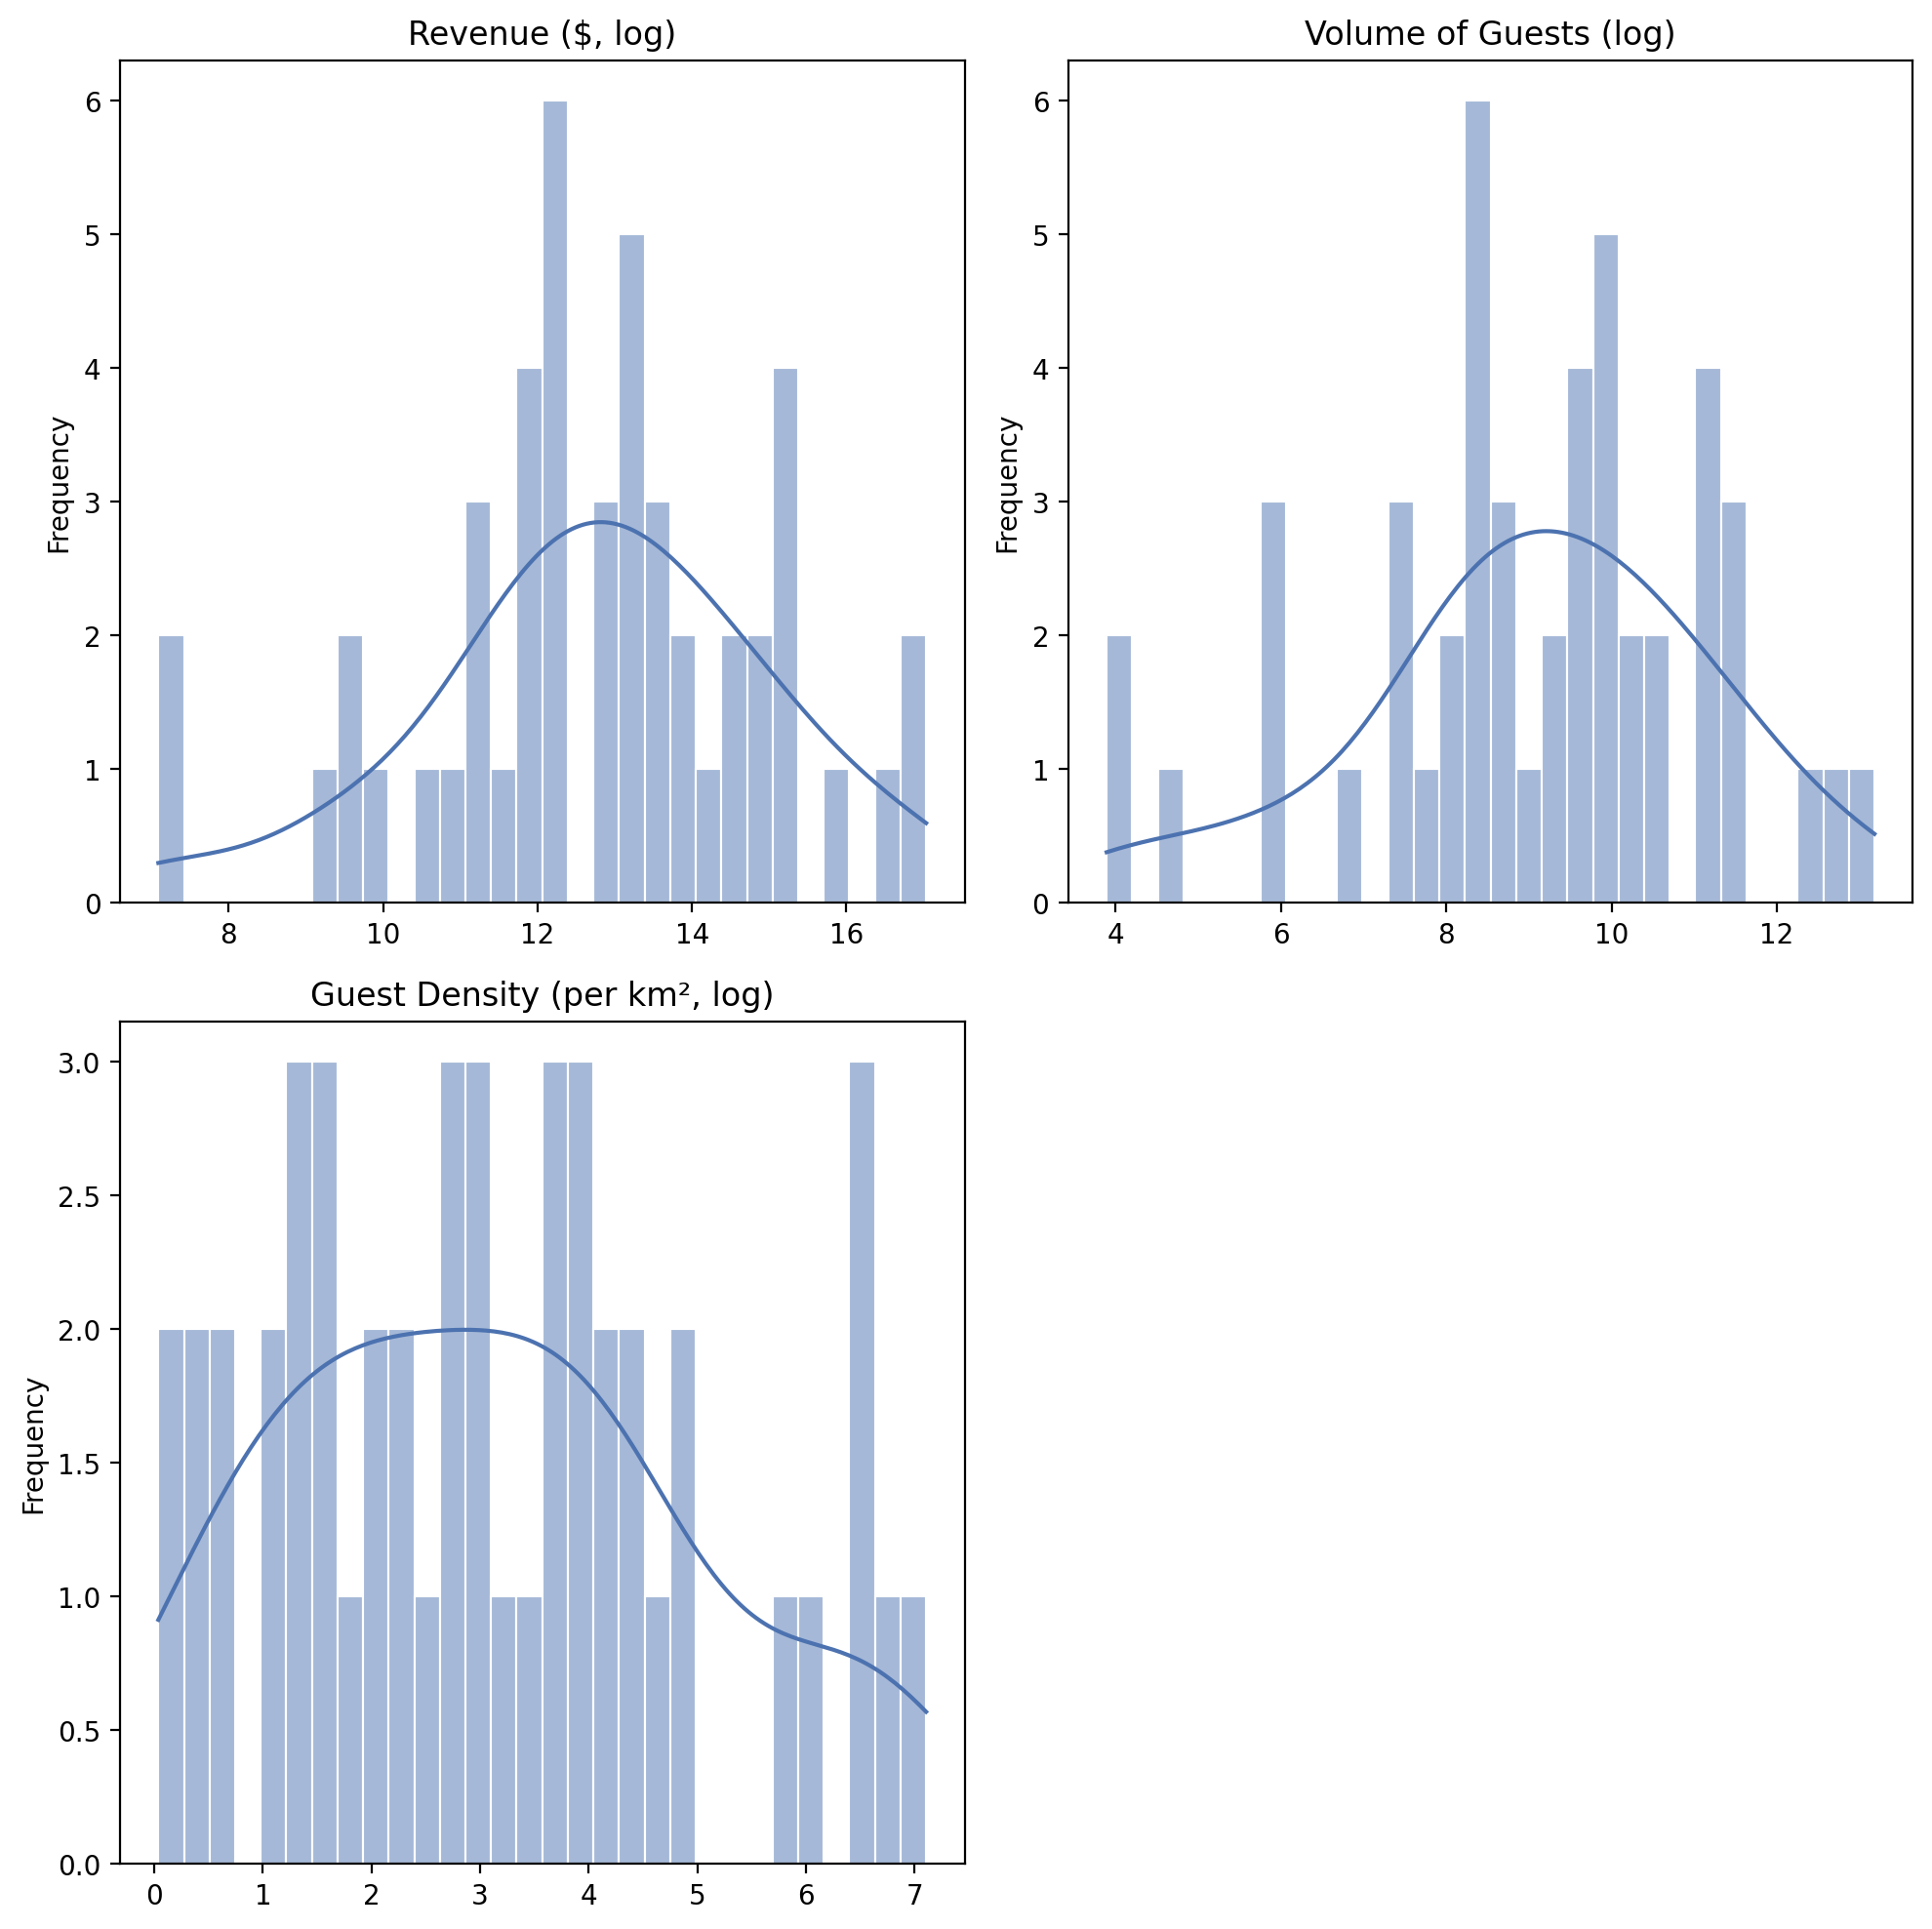

In [28]:
# Histograms of non-logged variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(airbnb_plot_cols_log):
    sns.histplot(
        data = airbnb_per_edinburgh_glx,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 30
    )
    axes[i].set_title(legend_titles_log.get(col, col), fontsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Turn off any unused subplots if columns < 6
for j in range(len(airbnb_plot_cols_log), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

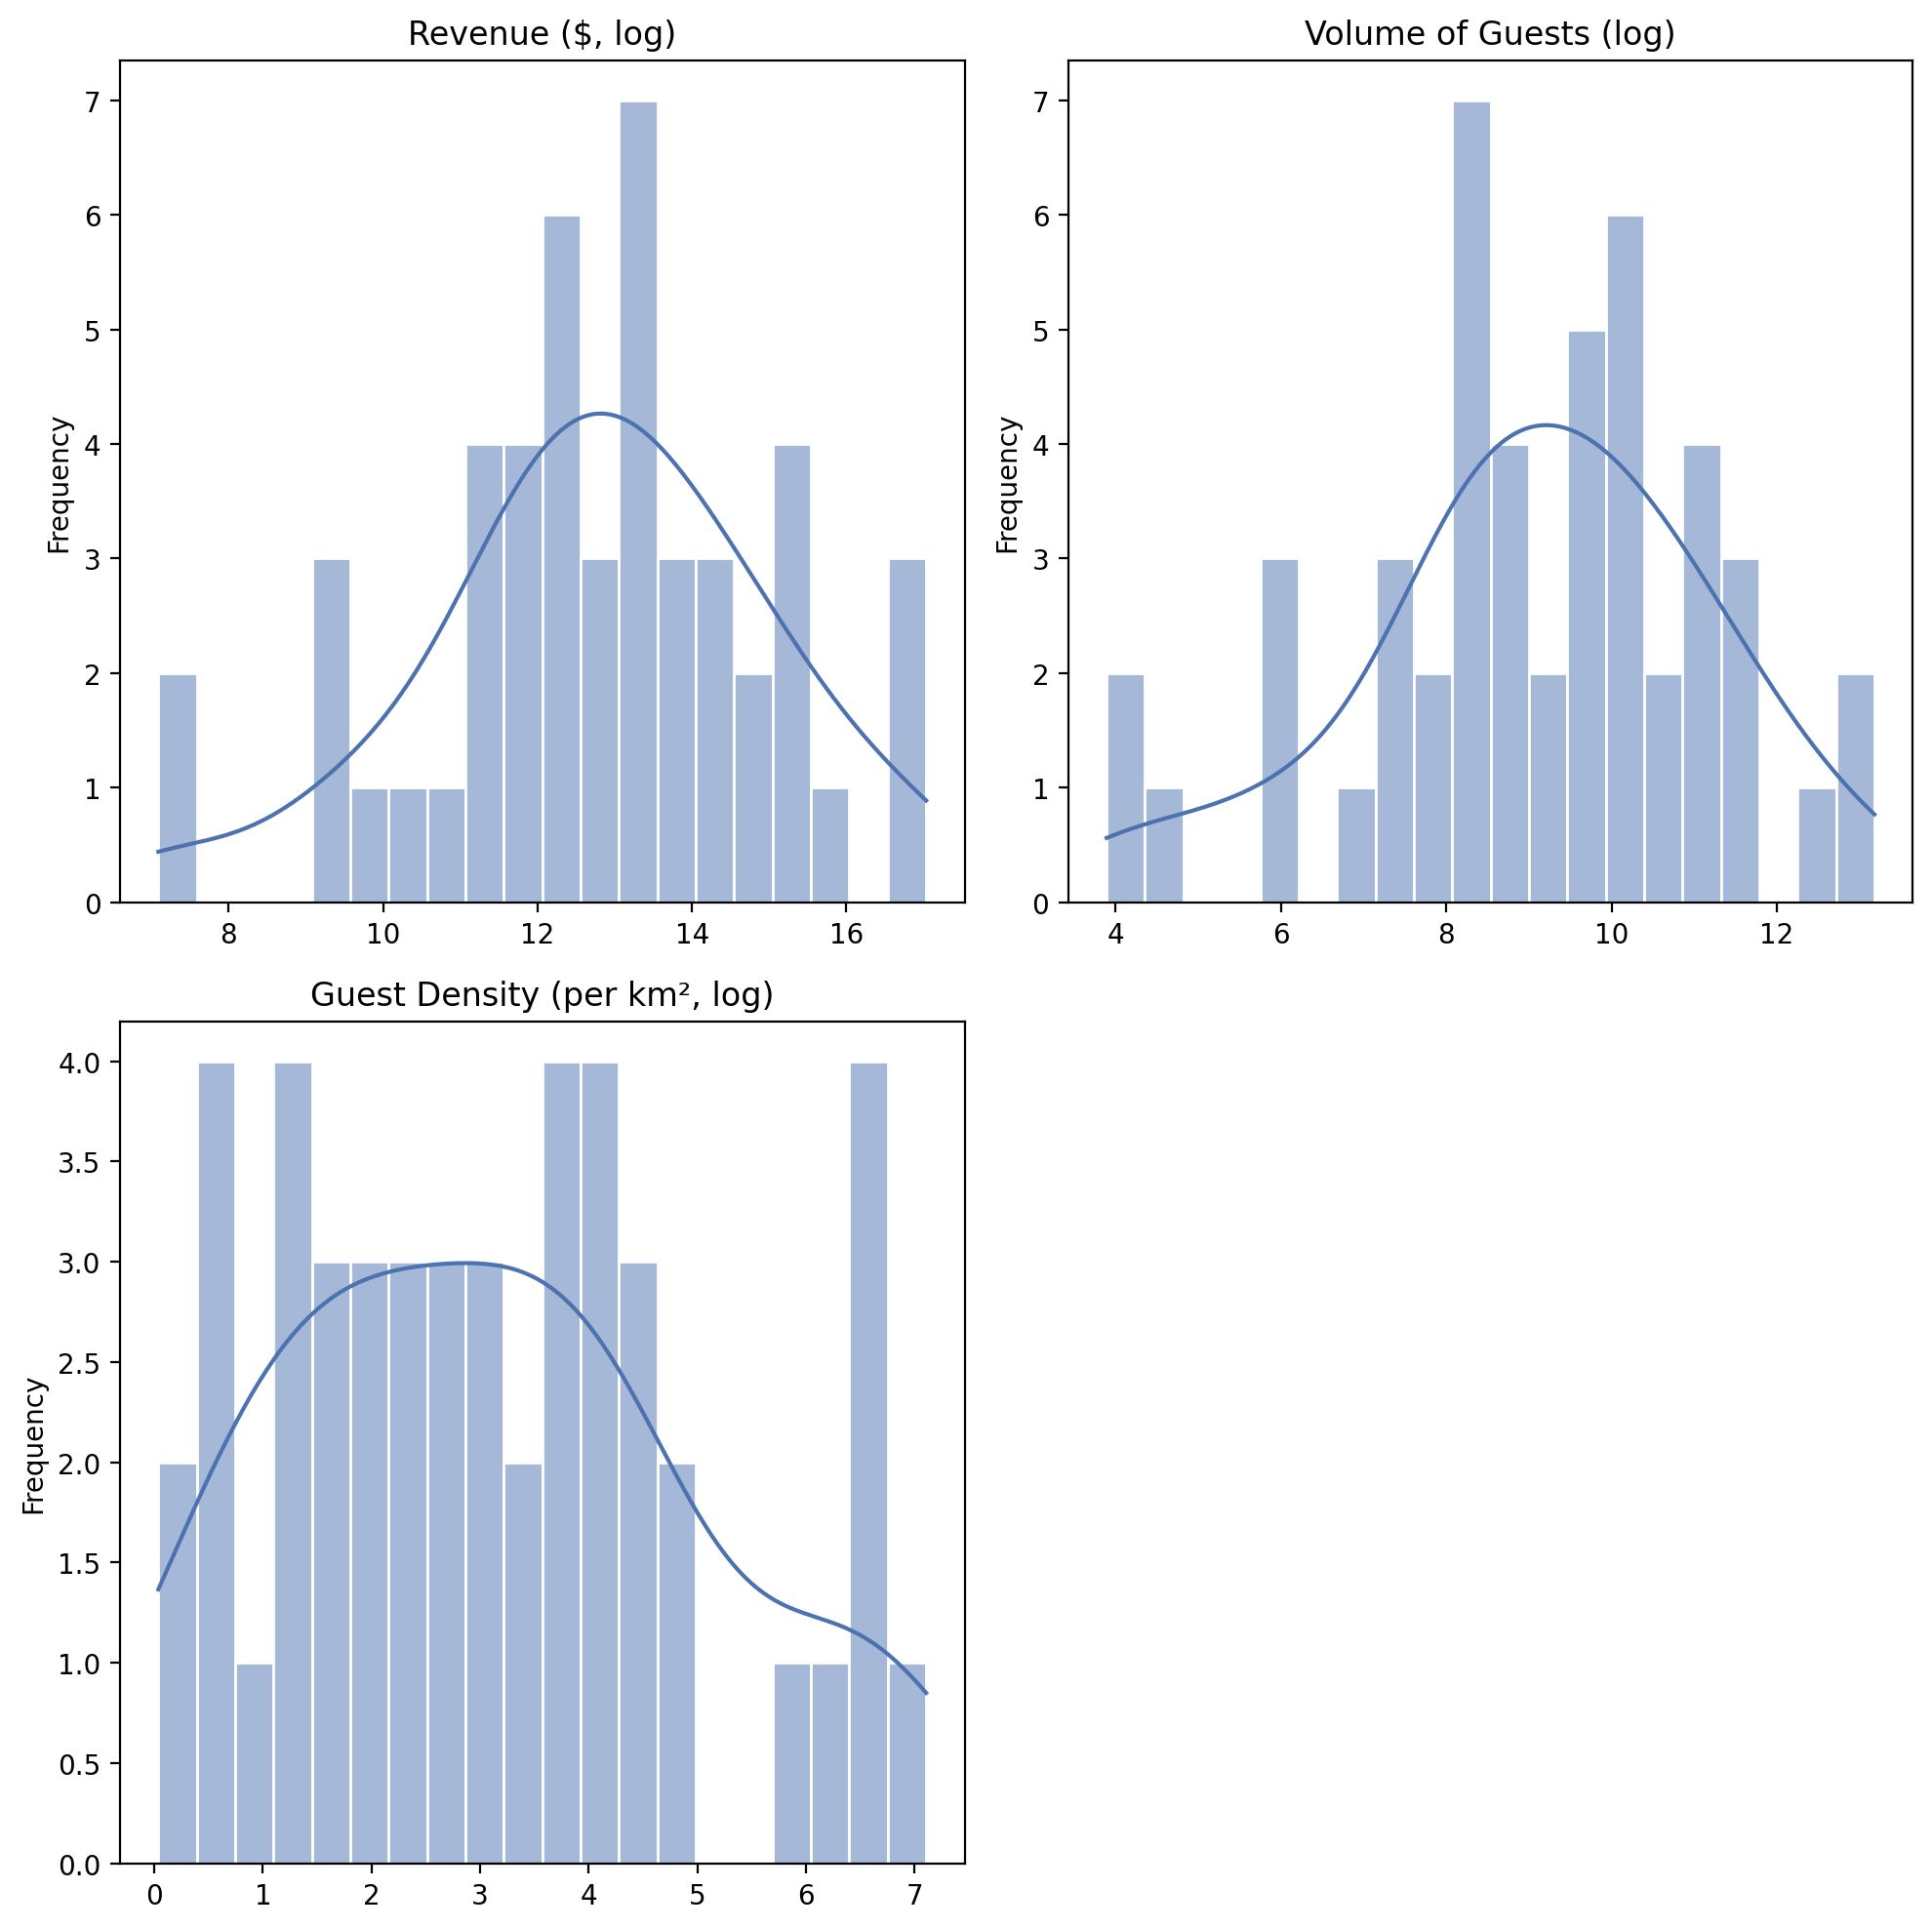

In [29]:
# Logged Histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

for i, col in enumerate(airbnb_plot_cols_log):
    sns.histplot(
        data = airbnb_per_edinburgh_glx,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 20
    )
    axes[i].set_title(legend_titles_log.get(col, col), fontsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Turn off any unused subplots if columns < 6
for j in range(len(airbnb_plot_cols_log), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Saved Cleaned Data

In [30]:
# Save airbnb_per_edinburgh_glx
airbnb_per_edinburgh_glx.to_file('../../data/edinburgh/airbnb_per_edinburgh_glx.gpkg', driver = "GPKG")